<a href="https://colab.research.google.com/github/CFVV/MSc-assignments/blob/main/2021-1_Deep_learning/T3_Reinforcement_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Tarea 03:  Reinforcement Learning
## Curso Deep Learning

Departamento de Ciencia de la Computación

Pontificia Universidad Católica de Chile

Camila F. Vera Villa


# Objetivo
Implementación del algoritmo **DQN**, el cual permite aprender politicas de acción para juegos de Atari.
En esta tarea nos centraremos en el juego Enduro.

**Enduro** consiste en maniobrar un auto de carreras en el National Enduro, una carrera de resistencia de larga
distancia. El objetivo de la carrera es adelantar un cierto numero de autos cada día. Hacerlo permitira que el
jugador continue compitiendo durante el día siguiente. El conductor debe evitar a otros corredores y pasar
200 autos el primer día y 300 autos cada día siguiente.

# 0. Setup Inicial

## Instalación de librerías necesarias

In [ ]:
from IPython.display import clear_output
import os
!pip install opencv-python
#!pip install gym==0.7.4
#!apt-get install -y xvfb python-pygame python-opengl
#!pip install pygame
#!git clone https://github.com/ntasfi/PyGame-Learning-Environment.git
#os.chdir('PyGame-Learning-Environment/')
#!pip install -e .
#!pip install pyvirtualdisplay gym_ple pygame

clear_output()
print('Librerías instaladas.')

Librerías instaladas.


In [ ]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(500, 500))
display.start()

## Enduro setup - Instalacion de roms

Correr solo una vez

In [ ]:
#!wget http://www.atarimania.com/roms/Roms.rar > /dev/null
# Decompresed files
#!unrar e Roms.rar > /dev/null
#!unzip 'ROMS.zip' > /dev/null
# Add Roms folder to atary_py PATH

In [ ]:
# Add Roms folder to atary_py PATH
!python -m atari_py.import_roms 'ROMS' > /dev/null

## Importación de librerías

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation
import random
import cv2
from IPython import display
#from IPython.display import HTML
import time
from collections import deque
from pathlib import Path

#Gym environment
import gym
from gym import wrappers
from gym import spaces
from gym.wrappers import AtariPreprocessing
from gym.wrappers import FrameStack
#from gym.wrappers import SkipWrapper

#import gym_ple
import math
import random
#plt.rcParams["figure.figsize"] = [25,30]
%matplotlib inline
#%config InlineBackend.figure_format = 'retina'

from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
torch.manual_seed(0)
np.random.seed(0)

from collections import deque

print('Librerías cargadas.')

Librerías cargadas.


GPU

In [ ]:
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Memoria

In [ ]:
torch.cuda.empty_cache()

In [ ]:
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 3            |        cudaMalloc retries: 484       |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |    5132 MB |    5139 MB |  345991 GB |  345986 GB |\n|       from large pool |      83 MB |     105 MB |  295140 GB |  295140 GB |\n|       from small pool |    5048 MB |    5049 MB |   50850 GB |   50845 GB |\n|---------------------------------------------------------------------------|\n| Active memory         |    5132 MB |    5139 MB |  345991 GB |  345986 GB |\n|       from large pool |      83 MB |     105 MB |

In [ ]:
!nvidia-smi

Tue Jun 29 19:56:31 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 106...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   49C    P2    22W /  N/A |   6075MiB /  6078MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#!kill 130645

# PARTE 1: Implementación

## Actividad 1.
**Realice el pre-procesamiento indicado a los estados del juego.**
**Respuesta:** ver implementación en código de más abajo.

**¿Por que usamos los últimos 4 pasos como input de la red para jugar Enduro?**

**Respuesta:** Como el agente solo puede ver cada n frames del juego, y sus acciones se repiten para cada frame, obteniendo todas las recompensas. Pasarle como input n=4 permite acelerar de forma efectiva el juego desde la perspectiva del agente, y también acelera el entrenamiento porque las recompensas se retrasan menos.


## Estados y preprocesamiento - Gym environment

In [ ]:
def _process_frame84(frame):
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    frame = frame[:155,10:]
    #x_t = cv2.resize(frame, (84, 84),  interpolation=cv2.INTER_LINEAR)
    x_t = cv2.resize(frame, (84, 84),interpolation=cv2.INTER_AREA)
    return x_t.astype(np.uint8)

class ProcessFrame84(gym.Wrapper):
    def __init__(self, env=None):
        super(ProcessFrame84, self).__init__(env)
        self.observation_space = spaces.Box(low=0, high=255, shape=(84, 84))

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        return _process_frame84(obs), reward, done, info

    def reset(self):
        return _process_frame84(self.env.reset())

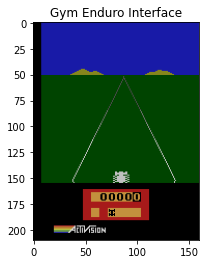

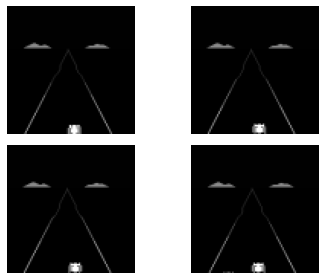

(4, 84, 84)


In [ ]:
#Create environment
game = 'Enduro-v0'
env = gym.make(game,frameskip=4)

# For reproducibility
seed = 25
env.seed(seed)

obs = env.reset()

plt.imshow(np.squeeze(obs))
plt.title('Gym Enduro Interface')
plt.show()

env = ProcessFrame84(env)
env = FrameStack(env,num_stack=4)
obs = env.reset()

for _ in range(100):
    action = random.randint(0,env.action_space.n-1)
    obs, reward, done, info = env.step(action)

plt.figure()
plt.subplot(2,2,1)
plt.imshow(np.squeeze(np.array(obs)[0,:,:]),cmap='gray')
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(np.squeeze(np.array(obs)[1,:,:]),cmap='gray')
plt.axis('off')
plt.subplot(2,2,3)
plt.imshow(np.squeeze(np.array(obs)[2,:,:]),cmap='gray')
plt.axis('off')
plt.subplot(2,2,4)
plt.imshow(np.squeeze(np.array(obs)[3,:,:]),cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()

print(obs.shape)

In [ ]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'reward', 'next_state', 'done'))

## Definición de clases y funciones auxiliares

In [ ]:
class PriorityReplayMemory:
    # extraído de https://github.com/bebound/flappy-bird-dqn/blob/master/flappy_priority_2frame_max250.ipynb
    def __init__(self, capacity, alpha=0.6, beta_start=0.4, beta_frames=100000):
        self.alpha = alpha
        self.buffer = deque(maxlen=capacity)
        self.priorities = deque(maxlen=capacity)

        self.beta_start = beta_start
        self.beta_frames = beta_frames
        self.frame = 1
        self.min_prio = 0.1

    def beta_by_frame(self):
        self.frame += 1
        return min(1.0, self.beta_start + self.frame * (1.0 - self.beta_start) / self.beta_frames)

    def __len__(self):
        return len(self.buffer)

    def push(self, sample):
        max_prio = max(self.priorities) if self.priorities else 1.0
        self.buffer.append(sample)
        self.priorities.append(max_prio ** self.alpha)

    def sample(self, batch_size):
        probs = np.array(self.priorities, dtype=np.float32)
        probs /= probs.sum()
        total = len(self.buffer)
        indices = np.random.choice(total, batch_size, p=probs, replace=True)
        samples = [self.buffer[idx] for idx in indices]

        beta = self.beta_by_frame()

        weights = (total * probs[indices]) ** (-beta)
        weights /= weights.max()

        return samples, indices, torch.Tensor(weights).to(device)


    def update_priorities(self, batch_indices, batch_priorities):
        for idx, prio in zip(batch_indices, batch_priorities):
            self.priorities[idx] = (prio + self.min_prio)** self.alpha

### Replay buffer

In [ ]:
class ReplayMemory:

    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, sample):
        """Saves a transition."""
        self.buffer.append(sample)

    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), batch_size, replace=True)
        samples = [self.buffer[idx] for idx in indices]
        return samples, None, torch.Tensor([1/len(self.buffer) for _ in range(batch_size)]).to(device)

    def update_priorities(self, batch_indices, batch_priorities):
        pass

    def __len__(self):
        return len(self.buffer)

## Actividad 2.
**Implemente el algoritmo de DQN utilizando a arquitectura de red Dueling DQN considerando las 3 estrategias.**


### Dueling DQN - Red neuronal con 4 frames

In [ ]:
class DDQN(nn.Module):

    def __init__(self, h, w):
        super().__init__()
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.bn3 = nn.BatchNorm2d(64)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 6, stride = 2, padding=0):
            return (size - kernel_size +2*padding ) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w,8,4),4,2),3,1)
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h,8,4),4,2),3,1)

        linear_input_size = convw * convh * 64
        fc_output_size=512
        self.fc_val=nn.Linear(linear_input_size, fc_output_size)
        self.fc_adv=nn.Linear(linear_input_size, fc_output_size)
        self.val = nn.Linear(fc_output_size, 1)
        self.adv = nn.Linear(fc_output_size, N_ACTION)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = x.float()
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))

        x_val = F.relu(self.fc_val(x.view(x.size(0), -1)))
        x_adv = F.relu(self.fc_adv(x.view(x.size(0), -1)))
        val=self.val(x_val)
        adv=self.adv(x_adv)


        x=val+adv-adv.mean(1,keepdim=True)
        return x

### Procesamiento y visualización de imagen

In [ ]:
process_pic = T.Compose([
                    T.ToPILImage(),
                    #T.Grayscale(),
                    T.Resize((84,84)),
                    T.ToTensor(),
                        ])

def get_screen_enduro():
    # Returned screen requested by gym is 400x600x3, but is sometimes larger
    # such as 800x1200x3. Transpose it into torch order (CHW).
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    _, screen_height, screen_width = screen.shape
    screen = screen[:, :int(screen_height * 0.8)]
    screen = screen.mean(0).astype('uint8')
    screen = torch.from_numpy(screen)
    screen = process_pic(screen.unsqueeze(0))
    screen = (screen*255).type(torch.uint8)

    return screen.unsqueeze(0).to(device)


In [ ]:
from IPython import display

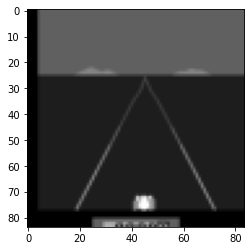

In [ ]:
def get_screen_cartpole():
    # Returned screen requested by gym is 400x600x3, but is sometimes larger
    # such as 800x1200x3. Transpose it into torch order (CHW).
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height*0.4):int(screen_height * 0.8)]

    screen = screen.mean(0).astype('uint8')
    screen = torch.from_numpy(screen)
    screen = process_pic(screen.unsqueeze(0))
    screen = (screen*255).type(torch.uint8)

    return screen.unsqueeze(0).to(device)

def get_screen_space():
    # Returned screen requested by gym is 400x600x3, but is sometimes larger
    # such as 800x1200x3. Transpose it into torch order (CHW).
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height*0.2):int(screen_height)]
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    screen = process_pic(screen)

    return screen.unsqueeze(0).to(device)

get_screen = get_screen_enduro
env.reset()

for _ in range(3):
    plt.clf()
    display.clear_output(wait=True)
    plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).squeeze(2).numpy(),cmap='gray')
    plt.pause(0.001)
    action = env.action_space.sample()
    env.step(action)

## Definición de hiperparámetros

In [ ]:
BATCH_SIZE = 32
GAMMA = 0.99 # Discounted return
EPS_START = 1 # Paso en que se comienza a utilizar la red para escoger acciones (siguiendo política e-greedy)
EPS_END = 0.005
ESP_END2 = 0.1
FRAME_SKIP = 4 # Cantidad de frames de cada estado (definido en el pre-procesamiento)
EPS_DECAY = 300000
EPS_DECAY2 = 50000
LOG_DECAY = False
TARGET_UPDATE = 1000 # Frecuencia en que se actualizan los pesos de la red target *
PLOT_INTERVAL = 50
REPLAY_SIZE= 20000 #Buffer primera iteración 10000
SAVE_CHECKPOINT=500
FULL_RANDOM=40000
OBSERVE = 20000
LR = 1e-6 #iteración 1 = 0.00025 #Tasa de aprendizaje teravon2: 1e-4
USE_PRIORITY_REPLAY = True
N_ACTION = env.action_space.n # Número de acciones
USE_BONUS_REWARD = False
LIMIT_MAX_REWARD = 300 #máxima recompensa. 250 en la primera iteración
CLIP_NORM=0.5

Define policy y target net

In [ ]:
init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape

# Define policy y target net
policy_net = DDQN(screen_height, screen_width).to(device)
target_net = DDQN(screen_height, screen_width).to(device)
print(policy_net)

DDQN(
  (conv1): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_val): Linear(in_features=3136, out_features=512, bias=True)
  (fc_adv): Linear(in_features=3136, out_features=512, bias=True)
  (val): Linear(in_features=512, out_features=1, bias=True)
  (adv): Linear(in_features=512, out_features=9, bias=True)
)


Definición de oprimizador

In [ ]:
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
#ADAM
#optimizer = optim.Adam(policy_net.parameters(),lr=LR)
#RMSPROP
optimizer = optim.RMSprop(policy_net.parameters(),lr=LR)

Memoria de estados

In [ ]:
# memoria de estados
if USE_PRIORITY_REPLAY:
    memory = PriorityReplayMemory(REPLAY_SIZE)
else:
    memory = ReplayMemory(REPLAY_SIZE)

Seleccionar acción

In [ ]:
def select_action(state):
    global action_q
    policy_net.eval()
    sample = random.random()
    if LOG_DECAY:
        eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * (steps_done - OBSERVE)/ EPS_DECAY)
    else:
        if not EPS_DECAY2:
            eps_threshold = max( EPS_START - (EPS_START - EPS_END)/EPS_DECAY *(steps_done - OBSERVE),EPS_END)
        else:
            # 0-EPS_DECAY: reduce threshold to EPS_END+ESP_END2, EPS_DECAY-EPS_DECAY2: reduce threshold to EPS_END
            if steps_done-OBSERVE<EPS_DECAY:
                eps_threshold = EPS_START - (EPS_START - EPS_END-ESP_END2)/EPS_DECAY *(steps_done - OBSERVE)
            else:
                eps_threshold = max( EPS_END+ESP_END2 - ESP_END2/EPS_DECAY2 *(steps_done - OBSERVE-EPS_DECAY),EPS_END)

    if not is_full_random() and sample > eps_threshold:
        with torch.no_grad():
            t=policy_net(state)
            action_q=t.max().item()
            return t.max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(N_ACTION)]], device=device, dtype=torch.long)

Plot durations

In [ ]:
#crear directorio base
base_dir= Path('/media/cami/CamiHDD/Camila/Documentos/Magister/Tarea3/dqn')
base_dir

PosixPath('/media/cami/CamiHDD/Camila/Documentos/Magister/Tarea3/dqn')

In [ ]:
import os

cwd = os.getcwd()  # Get the current working directory (cwd)
files = os.listdir(cwd)  # Get all the files in that directory
print("Files in %r: %s" % (cwd, files))

Files in '/media/cami/CamiHDD/Camila/Documentos/Magister/Tarea3': ['HC ROMS.zip', 'Tarea3_DL_correr.ipynb', 'dqn', 'Roms.rar', '.ipynb_checkpoints', '24H', 'ROMS.zip', 'ROMS', 'texto arrastrado.txt', 'plot2.png', 'Dueling Network Architectures for Deep Reinforcement Learning.pdf', 'Human-level control through deep reinforcement.pdf', 'atari_preprocessing.py', 'Nico_T3.ipynb', 'Tarea3_DL_CFVV.ipynb']


In [ ]:
#checkpoint_file=base_dir / 'dqn' / 'enduro2.pt'
checkpoint_file=base_dir / 'enduro4.pt'
print(checkpoint_file)
#temp_policy=base_dir / 'dqn' / 'best_score.pt'
temp_policy=base_dir / 'best_score4.pt'
print(temp_policy)

/media/cami/CamiHDD/Camila/Documentos/Magister/Tarea3/dqn/enduro4.pt
/media/cami/CamiHDD/Camila/Documentos/Magister/Tarea3/dqn/best_score4.pt


In [ ]:
def plot_durations():
    if i_episode%PLOT_INTERVAL==0:
        global action_qs
        plt.clf()
        display.clear_output(wait=True)
        rewards_t = torch.tensor(total_rewards, dtype=torch.float)
        bonus_rewards_t = torch.tensor(total_bonus_rewards, dtype=torch.float)
        action_qs_t = torch.tensor(action_qs, dtype=torch.float)
        plt.title('Entrenando, episodio:{},pasos:{},tiempo:{}s'.format(i_episode,steps_done,round(time_used)))
        plt.xlabel('Episodio')
        plt.ylabel('Score')
        plt.plot(action_qs_t.numpy(),label='Q')
        if USE_BONUS_REWARD:
            plt.plot(bonus_rewards_t.numpy(),label='bonus_score')
        plt.plot(rewards_t.numpy(),label='score')
        # Take 100 episode averages and plot them too
        if len(rewards_t) >= 100:
            means = rewards_t.unfold(0, 100, 1).mean(1).view(-1)
            means = torch.cat((torch.zeros(99), means))
            plt.plot(means.numpy(),label='score_mean')
        if len(action_qs_t) >= 100:
            means = action_qs_t.unfold(0, 100, 1).mean(1).view(-1)
            means = torch.cat((torch.zeros(99), means))
            plt.plot(means.numpy(),label='Q_mean')
        plt.rcParams["figure.figsize"] = [25,20]
        plt.legend()
        plt.savefig(base_dir /'plot3.png')
        plt.pause(0.00001)  # pause a bit so that plots are updated
        plt.close()

**Optimización del modelo**

- Transponer el batch: convierte el batch-array de Transiciones en Transición de batch-arrays.
- Calcular una máscara de estados no finales y concatena los elementos del batch
- Calcular Q (s_t, a)
- el modelo calcula Q (s_t), luego seleccionamos las columnas de acciones tomadas. Estas son las acciones que se habrían tomado para cada estado de batch de acuerdo con policy_net
- Calcular V (s_ {t + 1}) para todos los estados siguientes.
- Los valores esperados de acciones para non_final_next_states se calculan en función de "older" target_net; seleccionando su mejor recompensa con max (1).
- Esto se fusiona en función de la máscara, de modo que tendremos el valor de estado esperado o 0 en caso de que el estado sea final

In [ ]:
def optimize_model():
    policy_net.train()
    if len(memory) < BATCH_SIZE:
        return
    if steps_done<OBSERVE:
        return

    samples, ids, weights = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*samples)) # Transpose the batch

    # Compute a mask of non-final states and concatenate the batch elements
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.uint8)

    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the columns of actions taken.
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    with torch.no_grad():
        next_state_values = torch.zeros(BATCH_SIZE, device=device)
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
        expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    diff = state_action_values.squeeze() - expected_state_action_values.squeeze()
    loss=torch.zeros(diff.shape)
    for index,(i,j) in enumerate(zip(diff,weights)):
        if -1<i<1:
            loss[index]=(i * i)/2 * j
        else:
            loss[index]=(i.abs()-1/2)*j
    loss=loss.mean().to(device)
   #loss = F.mse_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    delta = diff.abs().detach().cpu().numpy().tolist()
    memory.update_priorities(ids, delta)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(policy_net.parameters(),CLIP_NORM)
    optimizer.step()

Checkpoint

In [ ]:
def save_checkpoint():
    torch.save({
                'i_episode': i_episode+1,
                'total_rewards':total_rewards,
                'total_bonus_rewards':total_bonus_rewards,
                'steps_done':steps_done,
                'policy_state_dict': policy_net.state_dict(),
                'target_state_dict': target_net.state_dict(),
                'optimizer' : optimizer.state_dict(),
                'time_used' : time_used,
            },checkpoint_file)

def load_checkpoint():
    global i_episode,policy_net,optimizer,steps_done,memory,total_rewards,time_used,total_bonus_rewards
    if os.path.exists(checkpoint_file):
        checkpoint=torch.load(checkpoint_file)
        i_episode=checkpoint['i_episode']
        total_rewards=checkpoint['total_rewards']
        total_bonus_rewards=checkpoint['total_bonus_rewards']
        steps_done=checkpoint['steps_done']
        time_used=checkpoint['time_used']
        optimizer.load_state_dict(checkpoint['optimizer'])
        policy_net.load_state_dict(checkpoint['policy_state_dict'])
        target_net.load_state_dict(checkpoint['target_state_dict'])

## Actividad 3
* **¿Cual es el beneficio de usar la arquitectura *Dueling DQN* comparado con la  arquitectura original de DQN para estimar el valor de $Q(s, a)$? , ¿Como se traduce este beneficio en la experiencia de juego de Enduro?**

**Respuesta:** Las *Deep Q-Networks* en teoría usan una red neuronal que toma cualquier par estado-acción $ (s, a) $  y genera un aproximado valor $ Q $ ,este $ Q $- value corresponden a qué tan bueno es estar en ese estado y realizar una acción en ese estado $ Q $ $ (s, a) $; pero en la práctica esto es mucho más eficiente con una red neuronal que tome un estado y genera un valor $ Q $ aproximado para cada acción posible usando un número manejable de parámetros. El problema de esta arquitectura, es que sobre estima el reward (es mayor) en comparación al reward real.

La arquitectura *Dueling DQN* se basa en la DQN: tiene capas convolucionales para procesar los frames del juego, sin embargo, Dueling DQN, a partir de ahí, dividie la red en dos partes (color magenta en la imagen inferior), una para estimar el valor del estado y el otro para estimar las ventajas de acción dependientes del estado. Después de las dos streams, el último módulo de la red combina el state-value y los outputs de ventaja.

El beneficio de usar esta arquitectura en comparación a la original DQN, es que al desacoplar la estimación, la  Dueling DQN puede aprender intuitivamente qué estados son (o no) valiosos sin tener que aprender el efecto de cada acción en cada estado (ya que también calcula el valor $V$ de estar en ese estado). La DQN original, necesita calcular el valor de cada acción en ese estado. Para el juego *Enduro*, al usarse Dueling DQN, se toman los frames de input y a partir de esto el modelo estima el valor del state y de la ventaja para cada posible acción (las 8 direcciones de la palanca de Atari y no hacer nada). Desde la mejor acción debería tomar ventaja de 0, el modelo resta la ventaja máxima de todas las ventajas previstas.



Imagen de Dueling Architecture, extraída de: https://www.freecodecamp.org/news/improvements-in-deep-q-learning-dueling-double-dqn-prioritized-experience-replay-and-fixed-58b130cc5682/

## Actividad 4
* **¿Cual es la ventaja de utilizar un buffer de memoria para los estados del juego?**

**Respuesta:** Un agente puede permanecer en la misma región de su entorno durante un tiempo, por lo que toda su experiencia será muy similar durante ese período de tiempo. Esto puede introducir algún sesgo en el algoritmo de aprendizaje. El agente puede ajustar su política para esta región del entorno, pero no funcionará tan bien como si se mueve fuera de esta región. Para resolver este problema, se utiliza una *replay memory* ; en lugar de utilizar solo las experiencias más inmediatas para el aprendizaje, el agente aprenderá basándose en un buffer de sus experiencias pasadas, recientes y no tan recientes, sin tener que recalcular los estados ya vistos, tornándose más eficiente en capacidad de cómputo y tiempo.

* **¿Por qué la estrategia de exploracion tipo $\epsilon$-greedy comienza con un valor grande que va disminuyendo?**

**Respuesta:** $\epsilon$-greedy en cada paso actúa aleatoriamente con probabilidad $\epsilon$, o con probabilidad greedily  1 - $\epsilon$.
Es bastante común que esta estrategia comience con un valor alto para $\epsilon$ (por ejemplo de 1.0), y luego reducirlo gradualmente (por ejemplo, bajo 0.005), ya que de esta manera dedicará cada vez más tiempo a explorar las partes interesantes del entorno, a medida que las estimaciones de Q-Value mejoran, sin dejar de pasar algún tiempo visitando regiones desconocidas del MDP y de esta manera todo el espacio de acción sea explorado.

## Actividad 5
 * **¿Cuantos parámetros entrenables tiene el modelo utilizado?**

Se utilizará la función ``def num_trainable_parameters ``para calcular la cantidad de parámetros.

In [ ]:
def num_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

Clase del modelo original DQN

In [ ]:
class DQN(nn.Module):
    def __init__(self, h, w):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, 2)
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

#### Parámetros modelo DQN

In [ ]:
modelo_dqn = DQN(screen_height, screen_width).to(device)

In [ ]:
print(modelo_dqn)

DQN(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (head): Linear(in_features=1568, out_features=2, bias=True)
)


In [ ]:
print(f"El modelo DQN tiene {num_trainable_parameters(modelo_dqn): }, parámetros entrenables")

El modelo DQN tiene  42978, parámetros entrenables


#### Parámetros modelo Dueling DQN

In [ ]:
modelo_ddqn = DDQN(screen_height, screen_width).to(device)

In [ ]:
print(modelo_ddqn)

DDQN(
  (conv1): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_val): Linear(in_features=3136, out_features=512, bias=True)
  (fc_adv): Linear(in_features=3136, out_features=512, bias=True)
  (val): Linear(in_features=512, out_features=1, bias=True)
  (adv): Linear(in_features=512, out_features=9, bias=True)
)


In [ ]:
print(f"El modelo Dueling DQN tiene {num_trainable_parameters(modelo_ddqn): } parámetros entrenables")

El modelo Dueling DQN tiene  3295722 parámetros entrenables


* **¿Cuántos parámetros de diferencia tiene el modelo de Dueling DQN en comparacion con el modelo de DQN original?**

In [ ]:
print(f" El modelo Dueling DQN tiene {(num_trainable_parameters(modelo_ddqn))- (num_trainable_parameters(modelo_dqn))} más parámetros entrenables que el modelo DQN original")

 El modelo Dueling DQN tiene 3252744 más parámetros entrenables que el modelo DQN original


## Actividad 6
**Indique todos los hiperparámetros y decisiones relevantes utilizadas para su implementación, tales como tasa de aprendizaje, metodo de optimización, tamaño de batch, y cualquier otro hiperparámetro utilizado.**

**Respuesta:**  Se realizaron varios experimentos (al rededor de 15) con distintas combinaciones de hiperparámetros (Learning rate: 1e-6, 0.00025,1e-4) optimizador:Adam y RMSPROM, target update:10.000, 1000 y replay_size: 1000, 10.000, 100.000, 200.000, 250.000, 450.000, 500.000) con el objetivo de mejorar el score medio y el rendimiento general del modelo, sin embargo, hubo grandes limitaciones por tema de memoria que no permitía terminar el entrenamiento principalmente con un *buffer de memoria* mayores a 200.000 steps. La mayoría de los entrenamientos duraron entre 8 y 25 horas con GPU.

Los **hiperparámetros** utilizados para la implementación con mejores resultados son los siguientes:

* BATCH_SIZE = 32
* GAMMA = 0.99  &#8594; Discounted factor
* LR = 1e-6  &#8594; Tasa de aprendizaje
* optimizer = optim.RMSprop(policy_net.parameters(),lr=LR)  &#8594; optimizador RMSPROP
* EPS_START = 1  &#8594; Paso en que se comienza a utilizar la red para escoger acciones (siguiendo política e-greedy)
* EPS_END = 0.005
* ESP_END2 = 0.1
* FRAME_SKIP = 4  &#8594;Cantidad de frames para cada estado (definido en el pre-procesamiento)
* EPS_DECAY = 300000
* EPS_DECAY2 = 50000
* LOG_DECAY = False
* TARGET_UPDATE = 1000  &#8594; Frecuencia en que se actualizan los pesos de la red target
* PLOT_INTERVAL = 50 &#8594; Largo del intervalo para graficar
* REPLAY_SIZE= 20000  &#8594; Buffer de memoria
* SAVE_CHECKPOINT=500 &#8594;Checkpoint para guardar los pesos y scores
* FULL_RANDOM=40000
* OBSERVE = 20000
* USE_PRIORITY_REPLAY = True
* N_ACTION = env.action_space.n  &#8594; Número de acciones
* USE_BONUS_REWARD = False
* LIMIT_MAX_REWARD = 300  &#8594; máxima recompensa. 250 en la primera iteración
* CLIP_NORM=0.5

## Actividad 7
Realice un gráfico que muestre la evolución del aprendizaje a través del entrenamiento. Específicamente, construya un gráfico que muestre el valor del score promedio por episodio en funcion de las épocas de entrenamiento. Para construir este grafico considere que una época está dada por el procesamiento  de 250 mil pasos de entrenamiento. Para el cálculo del score promedio considere los últimos 100 episodios.

**Gráfico 1:**

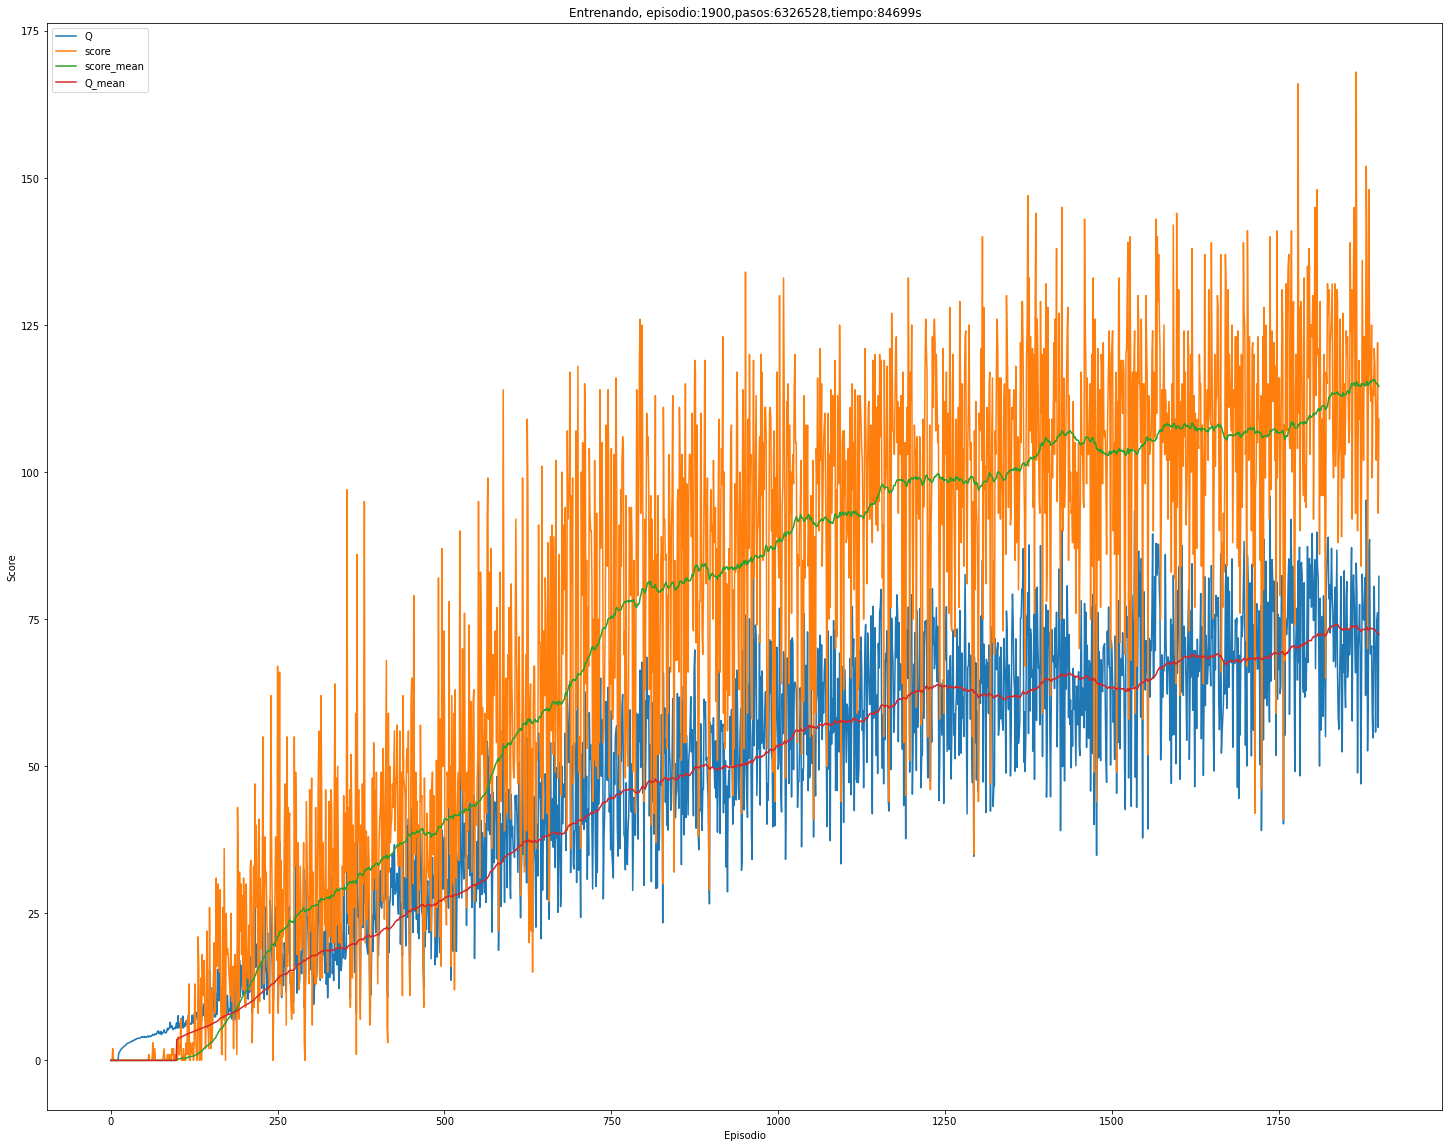

<ipython-input-98-9ddf85781d29>:27: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()


In [ ]:
resume=False

i_episode = 0
total_rewards = []
total_bonus_rewards = []
action_qs = []
steps_done = 0
time_used = 0
best_avg_score=-5

if resume:
    load_checkpoint()

def is_key_frame(t):
    return t%FRAME_SKIP==0

def is_full_random():
    return steps_done<FULL_RANDOM

for i_episode in count(i_episode):
    # Initialize the environment and state
    start_time=time.time()
    env.reset()
    total_reward=0
    total_bonus_reward=0
    last_screen = get_screen()
    current_screen = get_screen()
    screens = deque([current_screen] * 4, 4)
    state = torch.cat(list(screens), dim=1)
    last_action=None
    key_frame_reward=0.0
    action_q=None
    episode_q=[]

    for t in count():
        # Select and perform an action
        steps_done += 1
        if is_key_frame(t):
            action = select_action(state)
            last_action=action
            if action_q is not None:
                episode_q.append(action_q+total_reward)
        else:
            action=last_action
        _, reward, done, _ = env.step(action.item())
        total_reward+=reward
        key_frame_reward+=reward
        total_bonus_reward+=reward+0.05

        # Observe new state
        last_screen = current_screen

        if is_key_frame(t) or done:
            current_screen = get_screen()
            screens.append(current_screen)
        if not done:
            next_state = torch.cat(list(screens), dim=1)
        else:
            next_state = None


        # Store the transition in memory
        if is_key_frame(t) or done:
            if USE_BONUS_REWARD:
                bonus_reward_t = torch.tensor([reward+0.05], device=device)
                memory.push(Transition(state, action, bonus_reward_t, next_state, done))

            else:
                key_frame_reward_t=torch.tensor([key_frame_reward], device=device)
                memory.push(Transition(state, action, key_frame_reward_t, next_state, done))
                key_frame_reward=0

            if LIMIT_MAX_REWARD and total_reward>LIMIT_MAX_REWARD:
                True

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        optimize_model()

        if done:
            total_rewards.append(total_reward)
            total_bonus_rewards.append(total_bonus_reward)
            if episode_q:
                action_qs.append(sum(episode_q)/len(episode_q))
            else:
                action_qs.append(0)
            plot_durations()
            break

        if steps_done % TARGET_UPDATE==0 and not is_full_random():
            target_net.load_state_dict(policy_net.state_dict())

    if i_episode and i_episode%SAVE_CHECKPOINT==0 and not is_full_random():
        save_checkpoint()
    if len(total_rewards)>100:
        last_100_avg_rewards=sum(total_rewards[-100:])/100
        if last_100_avg_rewards>best_avg_score:
            best_avg_score=last_100_avg_rewards
            torch.save(policy_net,temp_policy)


    time_used+=time.time()-start_time

print('Complete')
env.render()
env.close()
# plt.ioff()
# plt.show()

print(sum(total_rewardsepisode_durations[-100:])/100)

En el **gráfico 1** (anterior) corresponde  al mejor entrenamiento obtenido de todas los experimentos realizados y muestra la evolución del aprendizaje a través del entrenamiento. En el eje X se muestran los episodios y en el Y el valor del score promedio por episodio en funcion de las épocas de entrenamiento.
Este entrenamiento se realizó en un tiempo de 86.983 segundos, que corresponden a poco más de **24 horas** y en **6.492.928 millones de steps**. Las líneas anaranjadas corresponden a los scores obtenidos en los **1950 episodios**, la línea verde corresponde al score medio, el cual en los últimos 100 episodios fue de aproximadamente **score_mean = 115** y el mejor score observado fue de **175**.

Las líneas azules corresponden a los **Q-values**, que indican cuan bueno es estar en ese estado y realizar una acción en ese estado Q(s,a), la línea roja corresponde a la media de estos valores durante todo el entrenamiento.

Cabe mencionar que durante la mayoría de los entrenamientos se observó alta varianza y fluctuaciones en el score y en el Q-value; esto se debe al fenómeno de **Catastrophic forgetting**, el cual aún es uno de los grandes problemas de los algoritmos de Reinforcement Learning. Esto ocurre porque el agente explora el entorno, actualiza su política, pero lo que aprende en una parte del entorno puede romper lo que aprendió recientemente en otras partes del entorno. Las experiencias están bastante correlacionadas y el entorno de aprendizaje sigue cambiando. Durante los experimentos, al observar un entrenamiento inestable, se probaron varios ajustes y combinaciones de hiperparámetros, principalmente con tendencia a aumentar el tamaño del **replay_buffer**, para que el algoritmo pudiese bajar el olvido catastrófico, además se probó reduciendo el **learning rate**, sin embargo, no siempre mejoró el desempeño.

**Gráfico 2:**

A modo de comparación a continuación se muestra el gráfico de entrenamiento de un experimento abordado con distinta combinación de hiperparámetros (Adam como optimizador, Buffer de 10.000 y LR: de 0.0025), en donde se observa alta varianza y el fenómeno de catastrophic forgetting.
Este entrenamiento tardó 25,4 horas, se generaron 2050 episodios y 6.825.728 millones de pasos,sin embargo, el score medio y máximo son inferiores al obtenido en el mostrado anteriormente


 ![image.png](attachment:03663b64-2aea-435a-9ad8-b9ab554abb5b.png)



# Referencias

1. http://proceedings.mlr.press/v48/wangf16.pdf
2. https://web.stanford.edu/class/psych209/Readings/MnihEtAlHassibis15NatureControlDeepRL.pdf
3. https://github.com/bebound/flappy-bird-dqn/blob/master/flappy_priority_2frame_max250.ipynb
4. https://towardsdatascience.com/dueling-deep-q-networks-81ffab672751
5. https://www.fromkk.com/posts/using-ddqn-to-play-flappy-bird/
6. https://rubenfiszel.github.io/posts/rl4j/2016-08-24-Reinforcement-Learning-and-DQN.html
7. https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
8. https://www.freecodecamp.org/news/improvements-in-deep-q-learning-dueling-double-dqn-prioritized-experience-replay-and-fixed-58b130cc5682/
9. Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition. Capítulo 18: Reinforcement Learning.
